In [1]:
import torchvision
from torchvision import datasets, transforms

class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image_id, sample, target) where target is class_index of
                the target class.
        """
        path, target = self.samples[index]
        #print(path)
        #print(target)
        img = self.loader(path)
        sample = self.transform(img)

        return target, sample

In [2]:
def get_transform():
    normalize = transforms.Normalize(
        #mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        #std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
        #[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        )
    transform = []
    transform.append(transforms.Resize([112, 112]))
    transform.append(transforms.ToTensor())
    transform.append(normalize)

    return transforms.Compose(transform)

In [3]:
data_dir = './datasets/cfp-dataset/Data/Images'

dataset = CustomDataset(data_dir, transform=get_transform())


In [4]:
from torch.utils import data

tr_loader = data.DataLoader(dataset=dataset,
                            batch_size=64,)

In [5]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



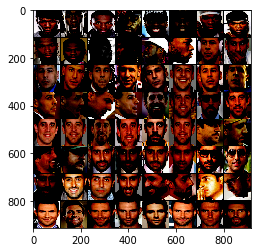

In [6]:
from PIL import ImageFile
# Make a grid from batch
(target, sample) = next(iter(tr_loader))
out = torchvision.utils.make_grid(sample)
imshow(out)

In [7]:
target

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4])

In [8]:
from backbone.muxnet import factory
from backbone.resnet import ResNet50
from backbone.ArcMarginProduct import ArcMarginProduct

In [9]:
net = factory('muxnet_l', pretrained=False, num_classes=512) 
#net = ResNet50()

In [10]:
margin = ArcMarginProduct(512, 500, s=64)


In [11]:
import torch

from torch.optim import lr_scheduler
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer_classi = optim.SGD([
    {'params': net.parameters(), 'weight_decay': 5e-4},
    {'params': margin.parameters(), 'weight_decay': 5e-4}
], lr=0.1, momentum=0.9, nesterov=True)
scheduler_classi = lr_scheduler.MultiStepLR(optimizer_classi, milestones=[20, 35, 45], gamma=0.1)

In [12]:
net = net.to(device)
margin = margin.to(device)

In [13]:
train_loader = data.DataLoader(dataset=dataset, shuffle=True,
                            batch_size=128,)

In [14]:
import os

def _find_classes(dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [15]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [16]:
def accuracy(scores, targets, k=1):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [17]:
import time

total_iters = 0
losses = AverageMeter()
top5_accs = AverageMeter()


for epoch in range(1, 61):
    

    print('Train Epoch: {}/{} ...'.format(epoch, 60))
    net.train()
    margin.train()
    since = time.time()
    for data in train_loader:
        label, img = data[0].to(device), data[1].to(device)
        feature = net(img)
        output = margin(feature, label)
        loss = criterion(output, label)

        
        optimizer_classi.zero_grad()
        loss.backward()
        optimizer_classi.step()
        
        losses.update(loss.item())
        top5_accuracy = accuracy(output, label, 5)
        top5_accs.update(top5_accuracy)
        total_iters += 1
        
        if total_iters % 50 == 0:
            
            _, predict = torch.max(output.data, 1)
            total = label.size(0)
            #print(label.data)
            #print(predict)
            correct = (np.array(predict.cpu()) == np.array(label.data.cpu())).sum()
            time_cur = (time.time() - since) / 100
            since = time.time()
            
            print('Epoch: [{0}][{1}/{2}]\t'
                        'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                        'Top5 Accuracy {top5_accs.val:.3f} ({top5_accs.avg:.3f})'.format(epoch, total_iters, len(train_loader),
                                                                                         loss=losses,
                                                                                         top5_accs=top5_accs))
            
        

Train Epoch: 1/60 ...
Epoch: [1][50/55]	Loss 48.1558 (48.8448)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 2/60 ...
Epoch: [2][100/55]	Loss 40.1043 (46.1483)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 3/60 ...
Epoch: [3][150/55]	Loss 37.6814 (43.7503)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 4/60 ...
Epoch: [4][200/55]	Loss 34.0970 (41.8942)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 5/60 ...
Epoch: [5][250/55]	Loss 30.6535 (40.0134)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 6/60 ...
Epoch: [6][300/55]	Loss 26.6944 (38.1291)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 7/60 ...
Epoch: [7][350/55]	Loss 21.7994 (36.1873)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 8/60 ...
Epoch: [8][400/55]	Loss 15.7501 (34.0184)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 9/60 ...
Epoch: [9][450/55]	Loss 21.8201 (32.4818)	Top5 Accuracy 0.000 (0.000)
Train Epoch: 10/60 ...
Epoch: [10][500/55]	Loss 21.7193 (31.3935)	Top5 Accuracy 0.000 (0.000)
Epoch: [10][550/55]	Loss 21.8101 (30.5008)	Top5 Accuracy 0.000 (0.000)
Train Ep